In [1]:
# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

In [2]:
# 데이터셋: 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus
# 데이터 다운로드 없이 Cloud shell에서 해당 파일의 심볼릭 링크를 연결
# $ ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

In [3]:
# 필요 라이브러리 가져오기 및 버전 확인

In [4]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [5]:
# 1) 데이터 준비와 확인

In [6]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
# 2) 데이터로더 구성

In [7]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [9]:
def load_data(train_data, test_data, num_words=10000):
    # 데이터의 중복 및 NaN 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    # 한국어 토크나이저로 토큰화 및 불용어(Stopwords) 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 사전word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>','<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [10]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [11]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

146182 146182
49157 49157


In [12]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [13]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [14]:
# 3) 모델 구성을 위한 데이터 분석 및 가공

In [15]:
# 데이터셋 내 문장 길이 분포 확인

전체 문장길이: 195339
문장 길이 평균 :  15.96940191154864
문장 길이 최대 :  116
문장 길이 표준편차 :  12.843571191092


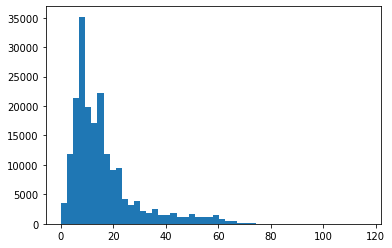

In [16]:
import matplotlib.pyplot as plt

# 전체 문장 길이
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print("전체 문장길이:", len(num_tokens))

# 문장 길이의 평균값, 최대값, 표준편차
print('문장 길이 평균 : ', np.mean(num_tokens))
print('문장 길이 최대 : ', np.max(num_tokens))
print('문장 길이 표준편차 : ', np.std(num_tokens))

# 문장 길이 분포 확인
plt.hist(num_tokens, bins=50)
plt.show()

In [17]:
# 적절한 최대 문장 길이 지정

In [18]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [19]:
# maxlen=41이 됩니다.

In [20]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)

X_test = pad_sequences(X_test, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [52]:
# 4) 모델 구성 및 validation set 구성

In [103]:
# validation set 구성(8:2)

In [22]:
val_size = 0.2
val_idx = round(len(X_train)*val_size)

print(val_idx)

# 학습용 데이터셋
X_train = X_train[val_idx:]  
y_train = y_train[val_idx:]

# validation 용 데이터셋
X_val = X_train[:val_idx]   
y_val = y_train[:val_idx]

29236


In [23]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(116946, 41) (116946,)
(29236, 41) (29236,)


In [ ]:
# 모델 구성

In [53]:
# 1) LSTM 모델

In [24]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_lstm = tf.keras.Sequential()
# [[YOUR CODE]]
model_lstm.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True))
model_lstm.add(tf.keras.layers.LSTM(10))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model_lstm.summary()

model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 10)                1080      
_________________________________________________________________
dense (Dense)                (None, 8)                 88        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 161,177
Trainable params: 161,177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
229/229 [==============================] - 43s 116ms/step - loss: 0.5594 - accuracy: 0.7469 - val_loss: 0.4631 - val_accuracy: 0.8566
Epoch 2/20
229/229 [==============================] - 25s 110ms/step - loss: 0.4485 - accuracy: 0.8522 

In [25]:
# 2) 1D CNN 모델

In [26]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_cnn = model_cnn.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [82]:
# 3) GRU 모델

In [27]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_gru = tf.keras.Sequential()
# [[YOUR CODE]]
model_gru.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True))
model_gru.add(tf.keras.layers.GRU(10))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_gru.add(tf.keras.layers.Dense(8, activation='relu'))
model_gru.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model_gru.summary()

model_gru.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_gru = model_gru.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
gru (GRU)                    (None, 10)                840       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,937
Trainable params: 160,937
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
229/229 [==============================] - 32s 122ms/step - loss: 0.5093 - accuracy: 0.7486 - val_loss: 0.3385 - val_accuracy: 0.8621
Epoch 2/20
229/229 [==============================] - 26s 116ms/step - loss: 0.3403 - accuracy: 0.857

In [28]:
# (6) Loss, Accuracy 그래프 시각화

In [29]:
# 1) LSTM 모델 시각화

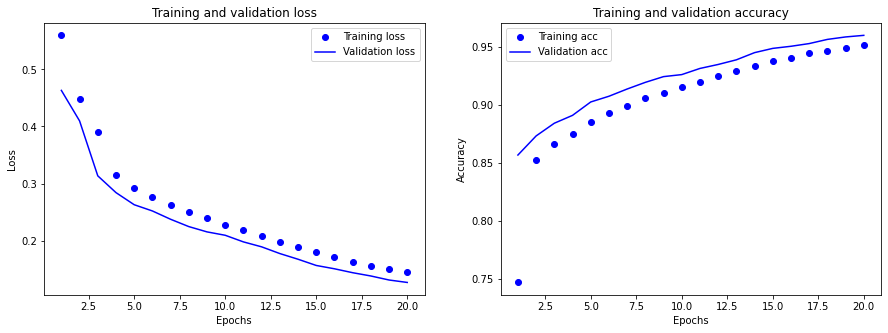

In [30]:
import matplotlib.pyplot as plt

history_dict = history_lstm.history

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [31]:
# 2) CNN 모델 시각화

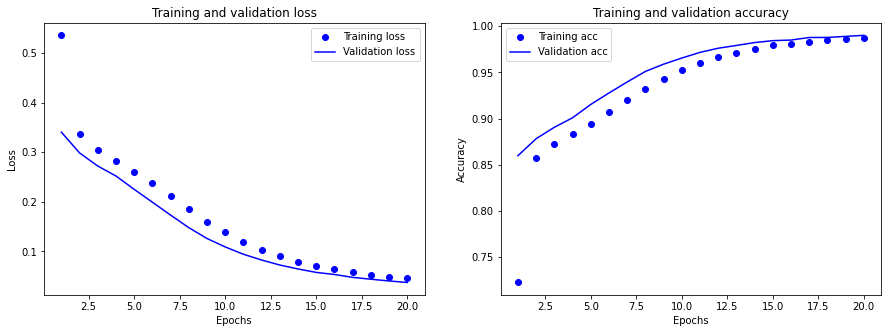

In [32]:
history_dict = history_cnn.history

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [33]:
# 3) GRU 모델 시각화

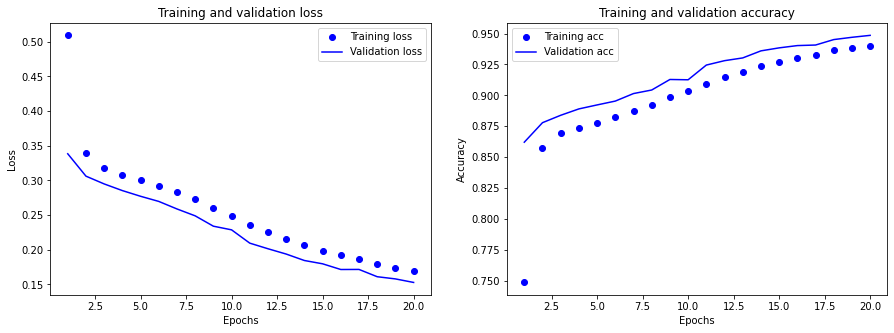

In [34]:
history_dict = history_gru.history

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [35]:
# 7) 학습된 Embedding 레이어 분석

In [36]:
# 워드 벡터 사이즈 확인

In [37]:
embedding_layer = model_gru.layers[0]
weights = embedding_layer.get_weights()[0]

In [38]:
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.


# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_gru.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [39]:
word_vectors.similar_by_word("즐거움")

[('”', 0.8404925465583801),
 ('우승', 0.825183093547821),
 ('파', 0.8110678195953369),
 ('절정', 0.7800052165985107),
 ('고증', 0.7705380320549011),
 ('코미디', 0.768239438533783),
 ('\\', 0.7612842321395874),
 ('링', 0.7357710599899292),
 ('받', 0.7288541197776794),
 ('외국인', 0.7245165705680847)]

In [40]:
word_vectors.similar_by_word("행복")

[('습니당', 0.9640495181083679),
 ('타고난', 0.9632546305656433),
 ('프렌즈', 0.9576611518859863),
 ('달래', 0.95588219165802),
 ('모세', 0.9556498527526855),
 ('부른', 0.953784704208374),
 ('서른', 0.9528241753578186),
 ('주군', 0.9522281289100647),
 ('전율', 0.9510546922683716),
 ('잠기', 0.9504210948944092)]

In [41]:
# 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [42]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv.similar_by_word("끝")

print(vector)

[('마지막', 0.6325399875640869), ('결판', 0.5526015758514404), ('발목', 0.5465342402458191), ('산산조각', 0.5418900847434998), ('막바지', 0.5412753820419312), ('싫증', 0.5256820917129517), ('양쪽', 0.5253474116325378), ('무릎', 0.5246764421463013), ('후', 0.5051813721656799), ('이어진', 0.5038793087005615)]


In [43]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [44]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [45]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 3s 7ms/step - loss: 0.6098 - accuracy: 0.6577 - val_loss: 0.4952 - val_accuracy: 0.7608
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.4603 - accuracy: 0.7850 - val_loss: 0.4061 - val_accuracy: 0.8185
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3934 - accuracy: 0.8241 - val_loss: 0.3525 - val_accuracy: 0.8470
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3513 - accuracy: 0.8454 - val_loss: 0.3205 - val_accuracy: 0.8638
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3226 - accuracy: 0.8614 - val_loss: 0.2974 - val_accuracy: 0.8741
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3032 - accuracy: 0.8711 - val_loss: 0.2773 - val_accuracy: 0.8845
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2838 - accuracy: 0.8819 - val_loss: 0.2652 - val_accuracy: 0.8910
Epoch 

In [46]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.5406 - accuracy: 0.8286


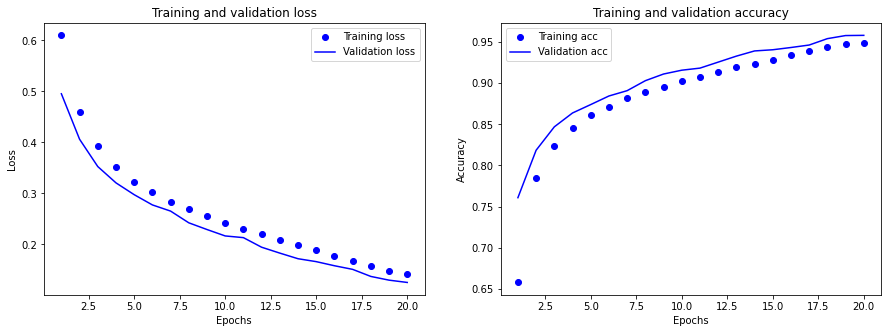

In [47]:
history_dict = history.history

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()